In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 250)
import numpy as np
import glob
import datetime

import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import scipy
import html
import pickle

## Read data

In [3]:
train = pd.read_csv("../training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None,
                   names=["target", "id", "date", "flag", "user", 'text'])

## Task 1 - target class distribution

In [4]:
train["target"].value_counts()

4    800000
0    800000
Name: target, dtype: int64

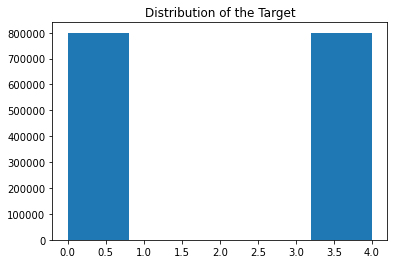

In [5]:
plt.hist(train["target"], bins=5)
plt.title("Distribution of the Target")
plt.show()

## Task 2 - Column Selection
- drop flag, since all are "no_query"

In [7]:
train["flag"].value_counts()

NO_QUERY    1600000
Name: flag, dtype: int64

## Task 3 - length of "text" column

In [8]:
train["text_len"] = train["text"].apply(lambda x: len(x))

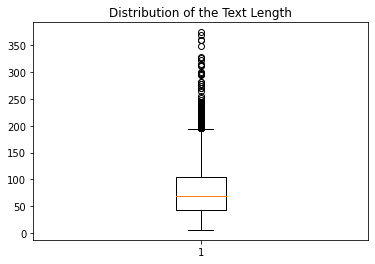

In [9]:
plt.boxplot(train["text_len"])
plt.title("Distribution of the Text Length")
plt.show()

## Task 4 - Decode html

In [10]:
train["text"] = pd.Series(list(map(html.unescape, train["text"])))

## Task 5 and 6
- remove @mention, url links, non-characters including #, numbers 
- punctuations and stop words
- convert to lower cases

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('treebank')
nltk.download('words')

stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

from string import punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/karenou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/karenou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     /Users/karenou/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package words to /Users/karenou/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [12]:
def remove(tokens):
    # remove @mention
    tokens = [re.sub(r'@[A-Za-z0-9]+', " ", token) for token in tokens]
    
    # remove url links
    tokens = [re.sub(r'https?://\S+|www\.\S+', "", token) for token in tokens]
    tokens = [re.sub(r'<.*?>', " ", token) for token in tokens]
    
    # remove non-characters including # and remove numbers
    tokens = [re.sub(r'[^a-zA-Z]', " ", token) for token in tokens]

    # convert to lower cases
    tokens = [token.lower() for token in tokens]

    return tokens

In [14]:
text = train["text"].values.tolist()

text = remove(text)

# remove stopwords, convert to lower case
text = [" ".join([token for token in tokens.split() if token not in stopwords]) for tokens in text]

# remove punctuation
text = [" ".join([token for token in tokens.split() if token not in punctuation]) for tokens in text]

## Task 7
- Deal with tokenization and stemming/lemmatization
- Create the embedding matrix with either count vectorizer or Tfidf vectorizer
- Save your cleaned data after the data processing as csv file.

In [15]:
def tokenize(text):
    return nltk.word_tokenize(text)

def stem(tokens):
    return [ps.stem(token) for token in tokens]

In [16]:
tokens = [tokenize(token) for token in text]
stemmed_tokens = [stem(token) for token in tokens]

In [58]:
# filter words in nltk.corpus.wordnet since there are many meaningless 
# word_corpus = set(nltk.corpus.words.words())
# filter_stemmed_tokens = [[word for word in sentence if word in word_corpus] for sentence in stemmed_tokens]

In [17]:
corpus = [" ".join(l) for l in stemmed_tokens]
train["clean_text"] = pd.Series(corpus)
train["clean_text"] = train["clean_text"].fillna(" ")
train[["target", "clean_text"]].to_csv("../Q7_output/Q7_clean.csv", index=False, header=True)

In [18]:
vectorizer = CountVectorizer()
embed_matrix = vectorizer.fit_transform(corpus)
scipy.sparse.save_npz("../Q7_output/embed_matrix.npz", embed_matrix)
embed_matrix.shape

(1600000, 222983)

## Task 8 - word cloud

In [19]:
from wordcloud import WordCloud

In [20]:
postive_words = train[train["target"] == 4]["clean_text"].tolist()
negative_words = train[train["target"] == 0]["clean_text"].tolist()

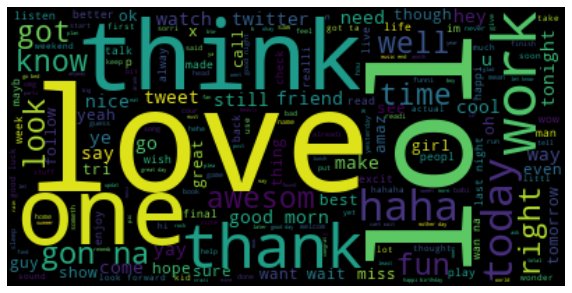

In [21]:
pos_wordcloud = WordCloud().generate(" ".join(postive_words))
fig = plt.figure(figsize=(10,10))
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("../Q7_output/positive_wordcloud.png")

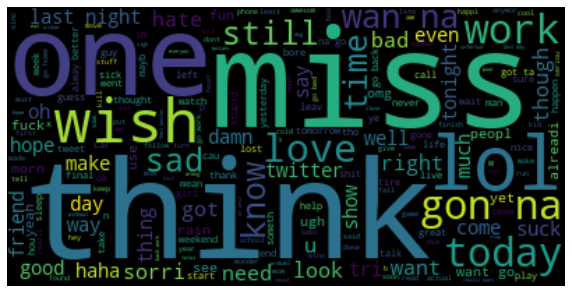

In [22]:
neg_wordcloud = WordCloud().generate(" ".join(negative_words))
fig = plt.figure(figsize=(10,10))
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("../Q7_output/negative_wordcloud.png")

## Task 9
- extract the term frequency data for positive text and negative text respectively

In [23]:
pos_index = train[train["target"] == 4].index.values.astype(int)
neg_index = train[train["target"] == 0].index.values.astype(int)

pos_corpus = np.array(corpus)[pos_index]
neg_corpus = np.array(corpus)[neg_index]

In [24]:
def get_frequency(vectorizer, emb_matrix, col_name):
    term_freq = emb_matrix.sum(axis=0).tolist()[0]
    words = vectorizer.get_feature_names()
    
    term_freq_dict = {}
    for i in range(len(words)):
        term_freq_dict.update({words[i]: term_freq[i]})
    
    term_freq_df = pd.DataFrame.from_dict(term_freq_dict, orient="index")
    term_freq_df.columns = [col_name]
    
    return term_freq_df

In [25]:
pos_vectorizer = CountVectorizer()
pos_embed_matrix = pos_vectorizer.fit_transform(pos_corpus)

neg_vectorizer = CountVectorizer()
neg_embed_matrix = neg_vectorizer.fit_transform(neg_corpus)

In [26]:
pos_term_freq_df = get_frequency(pos_vectorizer, pos_embed_matrix, "positive")
neg_term_freq_df = get_frequency(neg_vectorizer, neg_embed_matrix, "negative")

term_freq_df = pos_term_freq_df.join(neg_term_freq_df, how="outer")
term_freq_df["total"] = term_freq_df["positive"] + term_freq_df["negative"]
term_freq_df.to_csv("../Q7_output/Q7_freq.csv", index=True, header=True)

In [44]:
pos_embed_matrix.shape

(800000, 150303)

In [45]:
neg_embed_matrix.shape

(800000, 135439)

In [27]:
term_freq_df.sort_values("total", ascending=False).head(5)

,positive,negative,total
go,59341.0,79346.0,138687.0
get,49265.0,61577.0,110842.0
day,57048.0,52233.0,109281.0
good,62858.0,29692.0,92550.0
work,28792.0,58999.0,87791.0


## Task 10
- top 10 most frequent words for postive and negative tweets

In [31]:
def plot_frequency_words(df, col_name, top_k=50, figsize=(6,15)):
    df = df.sort_values(col_name, ascending=False)
    fig = plt.figure(figsize=figsize)
    plt.barh(df.index[:top_k][::-1], df[col_name][:top_k][::-1])
    plt.title("Top %d words in %s tweets" % (top_k, col_name))
    plt.savefig("../Q7_output/top_%d_frequent_words_%s_tweets.png" % (top_k, col_name))
    plt.show()

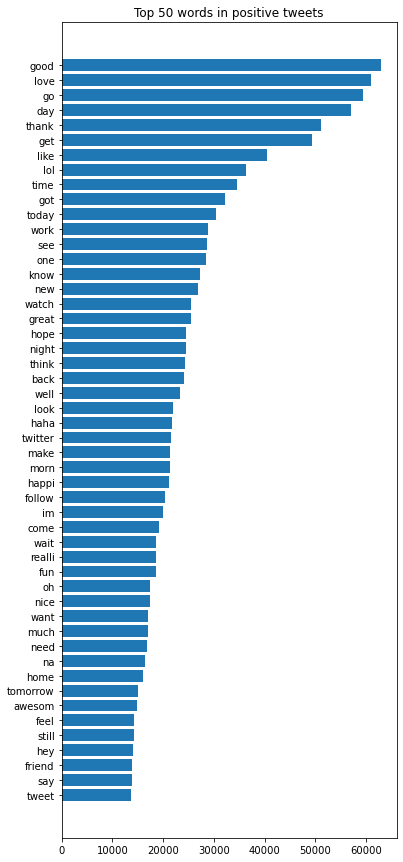

In [32]:
plot_frequency_words(term_freq_df, "positive", top_k=50)

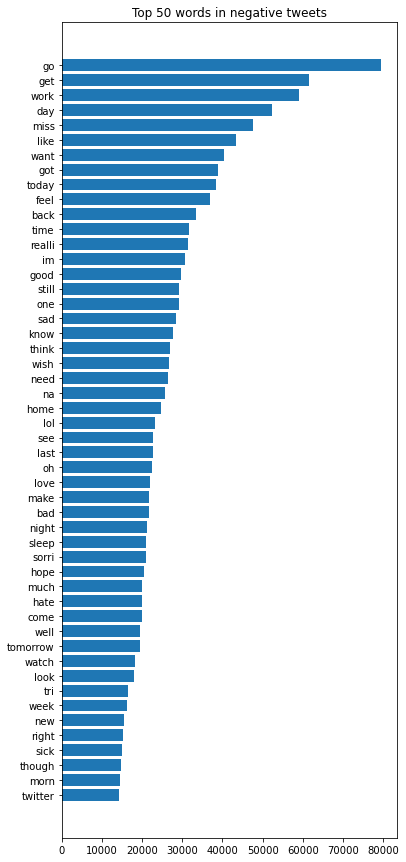

In [33]:
plot_frequency_words(term_freq_df, "negative", top_k=50)

## Task 11 - Logistic Regression

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [35]:
def split_train_test(df, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=0.2, random_state=0, stratify=df["target"])

    X_train = train_data['clean_text'].values
    y_train = train_data['target'].values
    X_test = test_data['clean_text'].values
    y_test = test_data['target'].values
    
    return X_train, y_train, X_test, y_test

def fit_vectorizer(x_train, x_test):
    train_vectorizer = CountVectorizer()
    vec_train = train_vectorizer.fit_transform(x_train)
    vec_test = train_vectorizer.transform(x_test)

    return train_vectorizer, vec_train, vec_test

In [36]:
def train_lr(x_train, y_train, x_test, y_test, C=1.0):

    classifier = LogisticRegression(C = C, random_state=100)
    classifier.fit(x_train, y_train)
    prediction = classifier.predict(x_test)
    score = (classifier.score(x_test, y_test))*100
    print('Accuracy score: ' + str(score) + '%')

    return classifier, prediction

In [50]:
# def clean_text(df):
#     df["text"] = pd.Series(list(map(html.unescape, df["text"])))
#     text = df["text"].values.tolist()
#     text = remove(text)
#     text = [" ".join([token for token in tokens.split() if token not in stopwords]) for tokens in text]
#     text = [" ".join([token for token in tokens.split() if token not in punctuation]) for tokens in text]
#     tokens = [tokenize(token) for token in text]
#     stemmed_tokens = [stem(token) for token in tokens]
#     filter_stemmed_tokens = [[word for word in sentence if word in word_corpus] for sentence in stemmed_tokens]
#     corpus = [" ".join(l) for l in filter_stemmed_tokens]
#     df["clean_text"] = pd.Series(corpus)
    
#     return df

# test = pd.read_csv("../testdata.manual.2009.06.14.csv", header=None, encoding="latin-1",
#                   names=["target", "id", "date", "flag", "user", 'text'])

# test = clean_text(test)

# X_train, y_train = data["clean_text"].values, data["target"].values
# X_test, y_test = test["clean_text"].values, test["target"].values

In [39]:
data = pd.read_csv("../Q7_output/Q7_clean.csv")
data["clean_text"] = data["clean_text"].fillna(" ")

In [40]:
X_train, y_train, X_test, y_test = split_train_test(data, test_size=0.2)

tran_vectorizer, vec_train, vec_test = fit_vectorizer(X_train, X_test)

In [41]:
lr_model, lr_pred = train_lr(vec_train, y_train, vec_test, y_test,
                            C = 5)

Accuracy score: 77.03999999999999%


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [42]:
pickle.dump(lr_model, open("../Q7_output/lr_model.pkl", 'wb'))